In [ ]:
!pip install ultralytics
!pip install torchprofile fast-pytorch-kmeans matplotlib


In [ ]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from tqdm.auto import tqdm

from ultralytics import YOLO

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

assert torch.cuda.is_available()


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ed01BVqTBrsUtDS3NpII")
project = rf.workspace("yolo-tr0yg").project("human_detection-kf2rg")
version = project.version(1)
dataset = version.download("yolov8")

print(f"Dataset downloaded to: {dataset}")

loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded to: <roboflow.core.dataset.Dataset object at 0x7a6e57b08750>


In [ ]:
model = YOLO("/content/best.pt")



In [ ]:
@torch.inference_mode()
def evaluate_yolo(model, data_yaml):
    """Evaluate YOLO model using mAP metrics"""
    results = model.val(data=data_yaml)
    return results.box.map

def get_model_macs(model, inputs) -> int:
    """Calculate the number of MACs for the model"""
    return profile_macs(model, inputs)

def get_sparsity(tensor: torch.Tensor) -> float:
    """Calculate sparsity of the given tensor"""
    return 1 - float(tensor.count_nonzero()) / tensor.numel()

def get_model_sparsity(model: nn.Module) -> float:
    """Calculate sparsity of the given model"""
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """Calculate the total number of parameters of model"""
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements

def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """Calculate the model size in bits"""
    return get_num_parameters(model, count_nonzero_only) * data_width

def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    """Plot histogram of weights for each layer"""
    fig, axes = plt.subplots(3, 3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0

    for name, param in model.named_parameters():
        if param.dim() > 1 and plot_index < len(axes):
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True, color='blue', alpha=0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, color='blue', alpha=0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1

    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

Dense model has size = 11.49 MiB
Dense model has parameters = 3.01M
Dense model sparsity = 0.0070


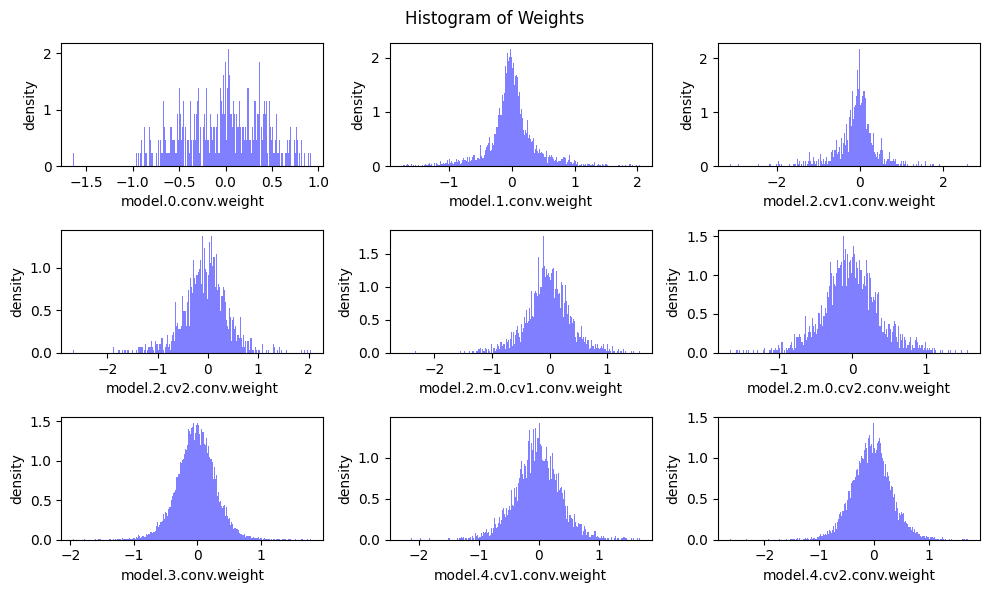

Dense model MACs = 4.06G


No handlers found: "aten::silu_". Skipped.
No handlers found: "aten::unbind". Skipped.
No handlers found: "aten::scalarimplicit". Skipped.
No handlers found: "aten::arange". Skipped.
No handlers found: "aten::meshgrid". Skipped.
No handlers found: "aten::full". Skipped.
No handlers found: "aten::split_with_sizes". Skipped.
No handlers found: "aten::unsqueeze". Skipped.


In [ ]:
dummy_input = torch.randn(1, 3, 640, 640).cuda()

yolo_model = model.model
yolo_model = yolo_model.cuda()

dense_model_size = get_model_size(yolo_model)
print(f"Dense model has size = {dense_model_size/MiB:.2f} MiB")
print(f"Dense model has parameters = {get_num_parameters(yolo_model)/1e6:.2f}M")
print(f"Dense model sparsity = {get_model_sparsity(yolo_model):.4f}")

plot_weight_distribution(yolo_model)

original_macs = get_model_macs(yolo_model, dummy_input)
print(f"Dense model MACs = {original_macs/1e9:.2f}G")

In [ ]:
def create_prunable_yolo_model(original_model):
    """
    Create a copy of the YOLO model that can be pruned
    :param original_model: Original YOLO model
    :return: Prunable copy of the model
    """
    from ultralytics.nn.tasks import DetectionModel
    new_model = DetectionModel(original_model.yaml)

    with torch.inference_mode(False):
        for name, param in original_model.named_parameters():
            if name in dict(new_model.named_parameters()):
                new_model.get_parameter(name).data.copy_(param.data.clone())

    return new_model


prunable_model = create_prunable_yolo_model(yolo_model)
sparsity_dict = create_sparsity_dict(prunable_model, uniform_sparsity=0.3)

pruner = FineGrainedPruner(prunable_model, sparsity_dict)



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [ ]:
def finetune_pruned_model(model, data_yaml, pruner, epochs=5):
    """
    Fine-tune the pruned model
    :param model: YOLO model
    :param data_yaml: path to data.yaml
    :param pruner: Pruner object
    :param epochs: number of fine-tuning epochs
    """
    best_map = 0
    best_model_state = None

    def apply_pruning_callback():
        pruner.apply(model.model)

    print("Fine-tuning pruned model...")
    for epoch in range(epochs):
        results = model.train(
            data=data_yaml,
            epochs=1,
            imgsz=640,
            batch=16,
            exist_ok=True,
            resume=True if epoch > 0 else False
        )

        apply_pruning_callback()

        val_results = model.val(data=data_yaml)
        current_map = val_results.box.map

        if current_map > best_map:
            best_map = current_map
            best_model_state = copy.deepcopy(model.model.state_dict())

        print(f"Epoch {epoch+1}/{epochs}: mAP = {current_map:.4f}, Best mAP = {best_map:.4f}")

    if best_model_state is not None:
        model.model.load_state_dict(best_model_state)

    return model, best_map


In [ ]:
def weight_prune_yolov8(model, prune_ratio=0.6, save_path=None):
    """
    Apply weight pruning to YOLOv8 model (keeps structure intact)
    :param model: YOLOv8 model
    :param prune_ratio: pruning ratio for weights
    :param save_path: path to save the pruned model (optional)
    :return: pruned model
    """
    pruned_model = copy.deepcopy(model)
    yolo_model = pruned_model.model

    print("Applying weight pruning to YOLOv8...")

    with torch.inference_mode(False):
        for name, module in yolo_model.named_modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                weight = module.weight.data

                threshold = torch.quantile(weight.abs(), prune_ratio)

                mask = weight.abs() > threshold

                module.weight.data = weight * mask

    print("Weight pruning completed!")

    if save_path is not None:
        try:
            pruned_model.save(save_path)
            print(f"Pruned model saved to: {save_path}")
        except Exception as e:
            print(f"Error saving model: {e}")
            try:
                torch.save(pruned_model.state_dict(), save_path)
                print(f"Pruned model saved as state dict to: {save_path}")
            except Exception as e2:
                print(f"Could not save model: {e2}")

    return pruned_model

In [ ]:
prune_ratio = 0.6
pruned_model = weight_prune_yolov8(
    model,
    prune_ratio=prune_ratio,
    save_path='yolov8_pruned.pt'
)

Applying weight pruning to YOLOv8...
Weight pruning completed!
Pruned model saved to: yolov8_pruned.pt


In [1]:
import os
import numpy as np
import onnx
import onnxruntime as ort
from onnxruntime.quantization import quantize_static, QuantType, CalibrationDataReader

onnx_path = '/content/best.onnx'
quantized_model_path = '/content/best_quantized.onnx'

original_size = os.path.getsize(onnx_path) / (1024 * 1024)
print(f"Original ONNX model size: {original_size:.2f} MB")

class YOLOCalibrationDataReader(CalibrationDataReader):
    def __init__(self, input_name):
        self.input_name = input_name
        self.datasize = 100
        self.current_index = 0

    def get_next(self):
        if self.current_index >= self.datasize:
            return None

        input_data = np.random.random((1, 3, 640, 640)).astype(np.float32)
        self.current_index += 1

        return {self.input_name: input_data}

    def rewind(self):
        self.current_index = 0

model = onnx.load(onnx_path)
input_name = model.graph.input[0].name
print(f"Model input name: {input_name}")

calibration_data_reader = YOLOCalibrationDataReader(input_name)

quantize_static(
    model_input=onnx_path,
    model_output=quantized_model_path,
    calibration_data_reader=calibration_data_reader,
    per_channel=False,
    reduce_range=False,
    weight_type=QuantType.QInt8
)

quantized_size = os.path.getsize(quantized_model_path) / (1024 * 1024)
print(f"Quantized ONNX model size: {quantized_size:.2f} MB")
print(f"Size reduction: {(1 - quantized_size/original_size) * 100:.2f}%")

session = ort.InferenceSession(quantized_model_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
input_name = session.get_inputs()[0].name
test_input = np.random.random((1, 3, 640, 640)).astype(np.float32)
outputs = session.run(None, {input_name: test_input})

print("Quantization completed successfully!")
print("The quantized model can now be used with ONNX Runtime.")

ModuleNotFoundError: No module named 'onnx'

In [ ]:
import os
import time
import numpy as np
import torch
from ultralytics import YOLO
from PIL import Image
import onnxruntime as ort
import glob
from tqdm import tqdm

original_model_path = '/content/best.pt'
quantized_model_path = '/content/best_pruned_quantized.onnx'
test_images_dir = '/content/human_detection-1/valid/images'

original_model = YOLO(original_model_path)
print(f"Original model loaded: {original_model_path}")

ort_session = ort.InferenceSession(
    quantized_model_path,
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
)
input_name = ort_session.get_inputs()[0].name
print(f"Quantized model loaded: {quantized_model_path}")

test_images = glob.glob(os.path.join(test_images_dir, '*.jpg'))
test_subset = test_images[:50]  # Test with 50 images

print("\n=== INFERENCE SPEED TEST ===")

print("Testing original model inference speed...")
original_times = []
for img_path in tqdm(test_subset):
    img = Image.open(img_path)
    start_time = time.time()
    results = original_model(img)
    original_times.append(time.time() - start_time)

print("Testing quantized model inference speed...")
onnx_times = []
for img_path in tqdm(test_subset):
    img = np.array(Image.open(img_path).resize((640, 640)))
    img = img.transpose(2, 0, 1)  # HWC to CHW
    img = np.expand_dims(img, 0).astype(np.float32) / 255.0

    start_time = time.time()
    ort_session.run(None, {input_name: img})
    onnx_times.append(time.time() - start_time)

print("\n=== DETECTION TEST ===")
print("Testing on a sample image...")

sample_img_path = test_subset[0]
img = Image.open(sample_img_path)

original_results = original_model(img)
original_detections = len(original_results[0].boxes)

img_array = np.array(img.resize((640, 640)))
img_array = img_array.transpose(2, 0, 1)  # HWC to CHW
img_array = np.expand_dims(img_array, 0).astype(np.float32) / 255.0

onnx_outputs = ort_session.run(None, {input_name: img_array})

onnx_detections = 0
if len(onnx_outputs) > 0 and len(onnx_outputs[0]) > 0:
    onnx_detections = onnx_outputs[0].shape[1]

original_size = os.path.getsize(original_model_path) / (1024 * 1024)
quantized_size = os.path.getsize(quantized_model_path) / (1024 * 1024)

print("\n=== COMPARISON RESULTS ===")
print(f"{'Metric':<20} {'Original Model':<20} {'Quantized Model':<20} {'Difference %':<15}")
print("-" * 75)
print(f"{'File Size (MB)':<20} {original_size:<20.2f} {quantized_size:<20.2f} {((quantized_size/original_size)-1)*100:<15.2f}")
print(f"{'Avg Inference (ms)':<20} {np.mean(original_times)*1000:<20.2f} {np.mean(onnx_times)*1000:<20.2f} {((np.mean(onnx_times)/np.mean(original_times))-1)*100:<15.2f}")
print(f"{'Min Inference (ms)':<20} {np.min(original_times)*1000:<20.2f} {np.min(onnx_times)*1000:<20.2f}")
print(f"{'Max Inference (ms)':<20} {np.max(original_times)*1000:<20.2f} {np.max(onnx_times)*1000:<20.2f}")
print(f"\nSample image detections - Original: {original_detections}, Quantized: {onnx_detections}")
print(f"\nSize reduction: {(1 - quantized_size/original_size) * 100:.2f}%")

Original model loaded: /content/best.pt
Quantized model loaded: /content/best_pruned_quantized.onnx

=== INFERENCE SPEED TEST ===
Testing original model inference speed...


  0%|          | 0/50 [00:00<?, ?it/s]


0: 640x640 7 Humans, 9.5ms
Speed: 2.4ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 1/50 [00:00<00:13,  3.76it/s]


0: 640x640 1 Human, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Humans, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Humans, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 Humans, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 13 Humans, 7.4ms
Speed: 1.6ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 6/50 [00:00<00:02, 19.52it/s]


0: 640x640 1 Human, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Humans, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 Humans, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Human, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Human, 7.4ms
Speed: 1.6ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 11/50 [00:00<00:01, 29.19it/s]


0: 640x640 5 Humans, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 Humans, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Humans, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 Humans, 7.4ms
Speed: 1.6ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Humans, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 Humans, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 17/50 [00:00<00:00, 36.36it/s]


0: 640x640 5 Humans, 7.4ms
Speed: 1.6ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 14 Humans, 7.4ms
Speed: 1.6ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Humans, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Humans, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Humans, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 22/50 [00:00<00:00, 39.90it/s]


0: 640x640 5 Humans, 7.4ms
Speed: 1.6ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Human, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 Humans, 7.4ms
Speed: 1.6ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 Humans, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 15 Humans, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 27/50 [00:00<00:00, 42.47it/s]


0: 640x640 5 Humans, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Human, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 Humans, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Human, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Human, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 32/50 [00:00<00:00, 44.39it/s]


0: 640x640 6 Humans, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Human, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 Humans, 12.2ms
Speed: 2.3ms preprocess, 12.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Human, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Humans, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 37/50 [00:01<00:00, 44.35it/s]


0: 640x640 3 Humans, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 Humans, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Humans, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Human, 7.4ms
Speed: 1.6ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Humans, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 Humans, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 43/50 [00:01<00:00, 46.25it/s]


0: 640x640 3 Humans, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Humans, 9.1ms
Speed: 1.6ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Human, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Human, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 48/50 [00:01<00:00, 47.09it/s]


0: 640x640 8 Humans, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Human, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


100%|██████████| 50/50 [00:01<00:00, 38.93it/s]


Testing quantized model inference speed...


100%|██████████| 50/50 [00:00<00:00, 54.77it/s]


=== DETECTION TEST ===
Testing on a sample image...

0: 640x640 7 Humans, 8.9ms
Speed: 1.9ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

=== COMPARISON RESULTS ===
Metric               Original Model       Quantized Model      Difference %   
---------------------------------------------------------------------------
File Size (MB)       5.97                 3.20                 -46.34         
Avg Inference (ms)   25.25                14.16                -43.93         
Min Inference (ms)   18.58                10.08               
Max Inference (ms)   265.31               78.46               

Sample image detections - Original: 7, Quantized: 6

Size reduction: 46.34%
